In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from LPSolver import LPSolver
import cvxpy as cp

In [3]:
rng = np.random.default_rng(10)

### Generate a feasible problem instance

In [4]:
m = 400  # number of equality constraints -- keep lower than number of variables to ensure there are multiple solutions to the problem
n = 650  # number of variables

A = rng.normal(size = (m,n))

random_row_index = np.random.choice(m)

# Set all entries in the selected row to their absolute values
A[random_row_index, :] = np.abs(A[random_row_index, :])

b = -A@np.abs(rng.normal(size = (n,)))
c = rng.normal(size = (n,))

### Create a LPSolver object

Can specify use_gpu = True if you want to run with a GPU. GPU solver typically starts to surpass performance of CPU solver ~500 variables (depending on system)

Also able to make multiple instances of this object to compare different hyperparameters

In [5]:
""""Initialize LP problem of form:
        Minimize c^T x
        Subject to Ax <= b
                   Cx == d
                   x >= 0

Can leave A, b, C, d, and c as None or specify matrices/vectors to constrain the problem
Set sign = +/- 1 if you want to constraint x to be positive or negative
"""

ls = LPSolver(c=c,
        A=A,
        b=b,
        C=None,
        d=None,
        use_gpu=False,
        sign=-1,
        t0=1,
        max_outer_iters=50,
        max_inner_iters=20,
        epsilon=1e-8,
        inner_epsilon=1e-5,
        check_cvxpy=True,
        linear_solve_method="cholesky",
        max_cg_iters=50,
        alpha=0.2,
        beta=0.6,
        mu=50,
        suppress_print=True)

#### Compare LPSolver solution to the CVXPY solution
Check the ls.value parameter if you want to extract the value of the solution, use ls.xstar to get the minimizer

In [9]:
ls.solve(track_loss=True)[0] - ls.cvxpy_val

5.587482786495457e-05

### Benchmark LPSolver times vs. CVXPY
Can also generate multiple instances of LP to benchmark times of different hyperparameters

In [7]:
%%timeit
x = cp.Variable(len(c))
obj = cp.Minimize(c.T@x)
constr = [A@x == b,
        x <= 0]
prob = cp.Problem(obj, constr)
prob.solve(solver='CLARABEL')   


1.38 s ± 5.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit ls.solve(resolve=True)

374 ms ± 1.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<Axes: title={'center': 'Convergence of LPSolver'}, xlabel='Cumulative Newton iterations', ylabel='Optimality gap'>

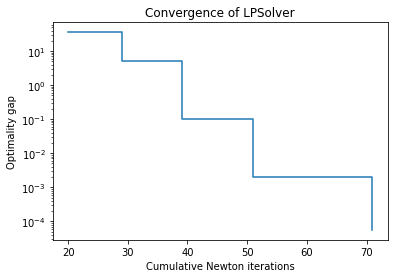

In [10]:
ls.plot()